In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def run_query(q):
    # use the with statement to access the context manager
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)
        
def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(q)

In [3]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Selecting Albums to Purchase

In [32]:
q = '''
WITH 
    track_sold_usa AS 
        (
        SELECT t.track_id, t.genre_id
        FROM track t
        INNER JOIN invoice_line il ON il.track_id = t.track_id
        INNER JOIN invoice i ON i.invoice_id = il.invoice_id
        WHERE billing_country = "USA"
        ),
    genre_usa_track_count AS
        (
        SELECT 
        g.name AS genre_name,
        COUNT(track_id) AS tracks_sold_number
        FROM genre g
        LEFT JOIN track_sold_usa tsu ON g.genre_id = tsu.genre_id
        GROUP BY 1
        )
SELECT 
    genre_name, 
    tracks_sold_number,
    tracks_sold_number/
    (
    SELECT TOTAL(tracks_sold_number)
    FROM genre_usa_track_count
    ) as tracks_sold_pct
FROM genre_usa_track_count
ORDER BY 2 DESC
LIMIT 10;
'''

run_query(q)

,genre_name,tracks_sold_number,tracks_sold_pct
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


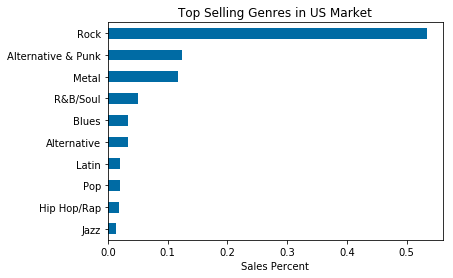

In [41]:
genre_sales_usa = run_query(q)

cb_dark_blue = (0/255, 107/255, 164/255)
ax = genre_sales_usa.plot(kind = 'barh',
                         x = 'genre_name', 
                          y = 'tracks_sold_pct', 
                         color = cb_dark_blue, 
                          title = 'Top Selling Genres in US Market',
                         legend = False,
                         )
ax.set(xlabel = "Sales Percent", ylabel = "")
plt.gca().invert_yaxis()

In the USA, Rock genre makes up more than half of the sales, followed by Alternative & Punk, Metal, etc.  
Based on the sales data in USA, we should purchase the following three albums:
* Red Tone (Punk)
* Slim Jim Bites (Blues)
* Meteor and the Girls (Pop)

However, if the record label has any Artist who produces Rock music, we should purchase that artist's albums.

## Analyzing Employee Sales Performance

In [42]:
q = '''
WITH customer_spend AS
    (
    SELECT 
        c.customer_id,
        c.support_rep_id,
        SUM(i.total) total_spend
    FROM customer c
    LEFT JOIN invoice i ON c.customer_id = i.customer_id 
    GROUP BY 1, 2
    )
SELECT 
    e.first_name || " " || e.last_name sales_name,
    hire_date,
    SUM(cs.total_spend) total_sales
FROM employee e
LEFT JOIN customer_spend cs ON e.employee_id = cs.support_rep_id
WHERE title = "Sales Support Agent"
GROUP BY 1, 2
ORDER BY 3 DESC;
'''
run_query(q)

,sales_name,hire_date,total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


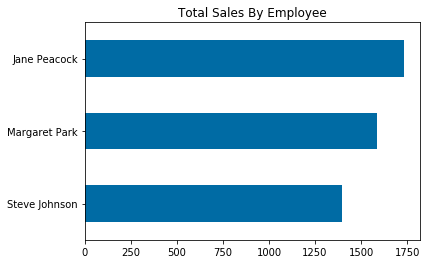

In [43]:
sales_performance = run_query(q)
ax = sales_performance.plot.barh(x = "sales_name", 
                            y = "total_sales",
                           title = "Total Sales By Employee",
                            color = [cb_dark_blue], 
                             legend = False
                           )
ax.set(ylabel = "")
plt.gca().invert_yaxis()

There are three Sales Support Agents in this company.  The top employee Jane Peacock's total sale is about 25% more compared to Steve Johnson.  However, the total sales is associated with hiring date: as expected, who entered the company earlier had higher total sales.  
So total sales is not a good metric to evaluate employee sales peformance.  Quarterly or Monthly sales maybe a better measurement.
## Analyzing Sales by Country
Use the country value from the customers table and ignore the country from the billing address in the invoice table.

In [29]:
q = '''
WITH 
    other_country AS
        (
        SELECT 
            country
        FROM customer
        GROUP BY 1
        HAVING COUNT(customer_id) = 1
        ),
    country_customer AS
        (
        SELECT
            customer_id,
            CASE 
                WHEN country IN other_country THEN "Other"
                ELSE country
                END AS country
        FROM customer
        ),
    country_total_customer AS
        (
        SELECT 
            country,
            COUNT(customer_id) total_customers
        FROM country_customer
        GROUP BY 1
        ),
    country_sale_order AS
        (
        SELECT
            country,
            SUM(total) total_sales,
            SUM(total)/COUNT(invoice_id) avg_order_value
        FROM country_customer cc
        LEFT JOIN invoice i ON cc.customer_id = i.customer_id
        GROUP BY 1
        ),
    country_table AS
        (
        SELECT 
            ctc.country,
            ctc.total_customers,
            cso.total_sales,
            cso.total_sales/ctc.total_customers avg_sales_per_customer,
            cso.avg_order_value,
            CASE
                WHEN ctc.country == "Other" THEN 1
                ELSE 0
            END AS sort
        FROM country_total_customer ctc
        INNER JOIN country_sale_order cso ON ctc.country = cso.country
        ORDER BY 3 DESC
        )
SELECT
    country,
    total_customers,
    total_sales,
    avg_sales_per_customer,
    avg_order_value
FROM country_table
ORDER BY sort ASC
'''

run_query(q)

,country,total_customers,total_sales,avg_sales_per_customer,avg_order_value
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,Other,15,1094.94,72.996000,7.448571


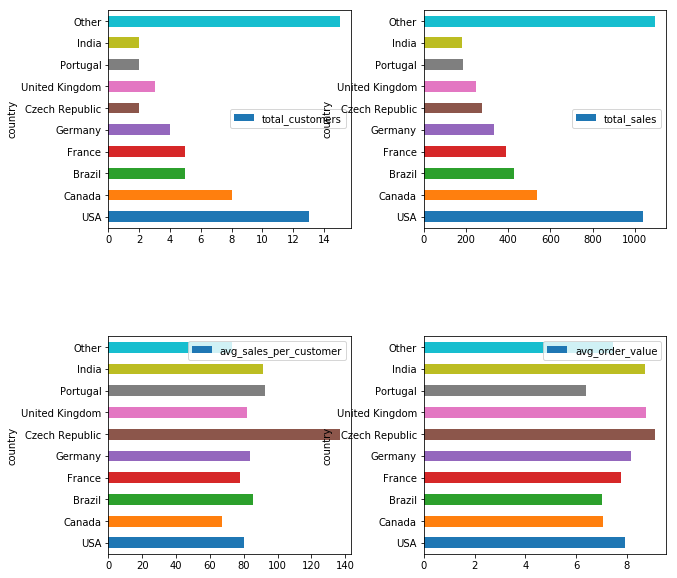

In [31]:
country_summary = run_query(q)
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 10))
fig.subplots_adjust(hspace=.5, wspace=.3)
country_summary.plot.barh(ax = axes[0, 0], x = "country", y = "total_customers")
country_summary.plot.barh(ax = axes[0, 1], x = "country", y = "total_sales")
country_summary.plot.barh(ax = axes[1, 0], x = "country", y = "avg_sales_per_customer")
country_summary.plot.barh(ax = axes[1, 1], x = "country", y = "avg_order_value")

USA had the largest number of customers and total sales.  However, Customers from Czech republic and India tend to spend more on average (by person or by each order) compared to all other countries. If the company could gain more customers from these two countries, they may make more purchases.  However, also of notice, the company only have 2 customers from both of these two countries, so we probably need more data before making more investment in Czech republic and India to see whether this higher behavior is really true.
## Albums vs. Individual Tracks

In [31]:
q = '''
WITH 
invoice_last_track AS
    (
    SELECT 
        il.invoice_id,     
        il.track_id last_track,
        t.album_id last_track_album
    FROM invoice_line il
    LEFT JOIN track t ON il.track_id = t.track_id 
    GROUP BY 1
    ),
    
invoice_category AS
    (
    SELECT
        invoice_id,
        CASE 
            WHEN 
                (
                SELECT track_id
                FROM invoice_line il
                WHERE il.invoice_id = ilt.invoice_id
                EXCEPT
                SELECT track_id
                FROM track t
                WHERE t.album_id = ilt.last_track_album
                ) IS NULL

                AND

                (
                SELECT track_id
                FROM track t
                WHERE t.album_id = ilt.last_track_album
                EXCEPT
                SELECT track_id
                FROM invoice_line il
                WHERE il.invoice_id = ilt.invoice_id
                ) IS NULL THEN "Yes"
            ELSE "No"
        END AS album_purchase
    FROM invoice_last_track ilt
    )
    
SELECT 
    album_purchase, 
    COUNT(invoice_id) number_invoices,
    CAST(COUNT(invoice_id) AS float)/(
        SELECT COUNT(*) FROM invoice_category) pct_invoices
FROM invoice_category
GROUP BY 1

'''

run_query(q)

,album_purchase,number_invoices,pct_invoices
0,No,500,0.814332
1,Yes,114,0.185668


18% of the orders are whole album purchases. If we decide to purchase only the most popular tracks from each album from record companies, we may lose this 18% revenue because the customer can no longer purchase the whole album from our site.  Thus I will recommend Chinook store continue to buy full albums from record companies.